In [ ]:
!pip install idx2numpy

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage

import numpy as np
import matplotlib.pyplot as plt
from idx2numpy import convert_from_file as load_idx
import time

In [ ]:
class MNIST(Dataset):

    def __init__(self):
        self.images = load_idx("t10k-images.idx3-ubyte")
        self.transforms = Compose([ToTensor(), Normalize(0.5, 0.5)])

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28, 1)
        image = self.transforms(image)
        return image

mnist = MNIST()
# subset_inds = list(range(2000))
# mnist = Subset(mnist, subset_inds)
loader = DataLoader(mnist, batch_size=32, shuffle=True)

In [ ]:
x_test = next(iter(loader))
x_test.shape

torch.Size([32, 1, 28, 28])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 4),
            nn.Conv2d(16, 32, 3, 4),
        )
        self.linear = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def block(self, in_features, out_features, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size, stride),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.disc(x)
        x = x.view(-1, 4*32)
        return self.linear(x)


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.linear = nn.Linear(latent_dim, 128*7*7)
        self.gen = nn.Sequential(
            self.block(128, 64, 2, 2),
            nn.ConvTranspose2d(64, 1, 2, 2),
            nn.Tanh(),
        )

    def block(self, in_features, out_features, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_features, out_features, kernel_size, stride),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(out_features)
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 128, 7, 7)
        x = self.gen(x)
        return x


latent_dim = 64
disc = Discriminator()
gen = Generator(latent_dim)

fixed_noise = torch.randn((32, latent_dim))

# hyperparameters

lr = 3e-4
epochs = 1000
disc_optim = optim.Adam(disc.parameters(), lr=lr)
gen_optim = optim.Adam(gen.parameters(), lr=lr)
loss_fn = nn.BCELoss()

disc.train()
gen.train()

for epoch in range(epochs):

    for batch, real in enumerate(loader):
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, latent_dim)
        fake = gen(noise)
        disc_real = disc(real)
        disc_fake = disc(fake)

        disc_loss = loss_fn(disc_real, torch.ones_like(disc_real)) + loss_fn(disc_fake, torch.zeros_like(disc_fake))
        disc_optim.zero_grad()
        disc_loss.backward(retain_graph=True)
        disc_optim.step()


        disc_fake = disc(fake)

        gen_loss = loss_fn(disc_fake, torch.ones_like(disc_fake))
        gen_optim.zero_grad()
        gen_loss.backward()
        gen_optim.step()

        print(f"\repoch {epoch+1}/{epochs} batch {batch}/{len(loader)} -- d_loss: {disc_loss.item()} -- g_loss: {gen_loss.item()}", end="")



epoch 8/1000 batch 217/313 -- d_loss: 1.4418137073516846 -- g_loss: 0.6959368586540222

KeyboardInterrupt: ignored

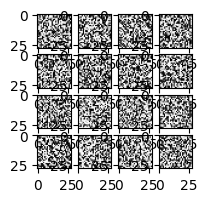

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

noise = torch.randn(16, 64)
gen.eval()
images = gen(noise)
fig = plt.figure(figsize=(2, 2))

for i, image in enumerate(images):
  fig.add_subplot(4, 4, i+1)
  image = (image - image.min())/(image.max() - image.min())
  image = ToPILImage()(image)
  plt.imshow(image, cmap="gray")